# Lab: Image Autoencoder with CNNs


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this notebook, we'll build a convolutional autoencoder to compress the CIFAR10 dataset. The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

PRÁCTICA 4 - REDES NEURONALES - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

Usaremos un autoencoder convolucional para comprimir el dataset "CIFAR10". El encoder se construirá con capas convolucionales y de pooling; con ello llegaremos a la capa hidden donde los datos están comprimidos y tras ello pasaremos a la capa decoder construida por capas convolucionales transpuestas (es el inverso a las capas convolucionales) con el fin de obtener a la salida, lo mismo que introduciamos a la entrada de la red.

In [1]:
# Representamos en una imágen el funcionamiento del Autoenconder a desarrollar.

from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://iq.opengenus.org/content/images/2019/03/autoencoder_1.png", width=800, height=200)

Introducimos una imágen cualquiera, codificamos, obtenemos los datos con dimensionalidad reducida y, finalmente, con la capa decoder obtenemos a la salida el mismo datos que habiamos introducido a la entrada.

## Part I. Load CIFAR10. Visualize images

Lets copy code that we've used in previous labs to load, normalize and visualize CIFAR10 images.

In [2]:
# Importamos las librerías necesarias para el desarrollo de la práctica

import torch
from torch import nn
from torch import optim
import numpy as np
from torchvision import datasets, transforms, utils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

d:\anaconda\envs\ids\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Necesito importar esto para poder descagar el dataset "CIFAR10" sin que me de error.

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# Obtenemos el conjunto de entrenamiento y test normalizado del dataset "CIFAR10"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalizamos las tres dimensiones anchoxaltoxprofundidad

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

# En este caso tomamos batches de 256 imágenes tanto en entrenamiento como en test.

Files already downloaded and verified
Files already downloaded and verified


En este caso no cargamos las clases ya que no nos hacen falta. El objetivo es la codificación y decodificación de una imagen de entrada, independientemente de su clase o etiqueta.

Lets visualize one image ...

torch.Size([3, 32, 32])


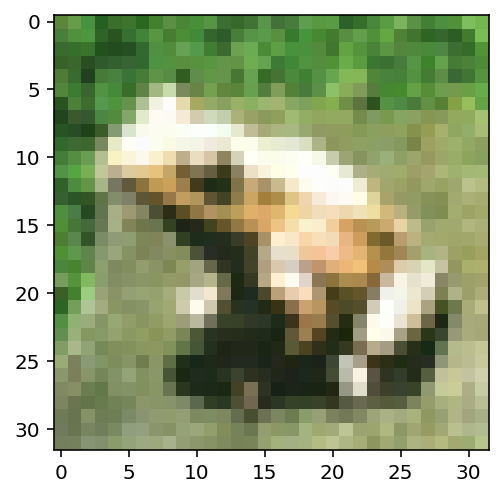

In [5]:
traindata = iter(trainloader)       # Introducimos los datos de entrenamientos en un iterador

images, labels = next(traindata)    # Cogemos el primer batch de 256 imágenes

print(images[1].shape)              # Vemos que nuestras imágenes son de 32x32 RGB

def rescale(img):                   # Reescalado desnormalizando las imágenes para plotearlas
    img = img / 2 + 0.5             # unnormalize to pot
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

plt.imshow(rescale(images[0,:,:,:]))# Cogemos la imagen 0 y dentro de esta, el altoxancho de las 3 matrices que represetan red, green and blue. 
                                    # De esta forma la representamos y comprobamos que hemos cargado correctamente el dataset

Representamos la imagen desnormalizada. Lógicamente se ve borrosa ya que ponemos en un plot "relativamente grande" una imágen de solo 32x32 píxeles (son MUY pocos).

Podríamos (como en prácticas anteriores) representar en el mismo plot el batch completo, sin embargo, al ser 256 imágenes en este caso y no 64, son demasiadas y no se podrían apreciar prácticamente.

> **Exercise**: Check the range of every pixel in a normalized image. This will help you to select the appropiate activation function in the autoencoder.

In [6]:
# Veamos una imagen cualquiera
images[4]

tensor([[[0.8980, 0.8980, 0.9059,  ..., 1.0000, 1.0000, 1.0000],
         [0.8588, 0.8588, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
         [0.8588, 0.8667, 0.8745,  ..., 0.9765, 0.9922, 1.0000],
         ...,
         [0.8745, 0.9216, 0.9294,  ..., 0.9686, 0.9843, 0.9686],
         [0.8745, 0.8745, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
         [0.9216, 0.9294, 0.9373,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9373, 0.9373, 0.9451,  ..., 0.9922, 1.0000, 1.0000],
         [0.8980, 0.8980, 0.9059,  ..., 1.0000, 1.0000, 1.0000],
         [0.8980, 0.9059, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8902, 0.9373, 0.9451,  ..., 0.9843, 0.9765, 0.9608],
         [0.8824, 0.8824, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
         [0.9216, 0.9294, 0.9373,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.8902, 0.8902, 0.8980,  ..., 1.0000, 1.0000, 1.0000],
         [0.8510, 0.8510, 0.8588,  ..., 1.0000, 1.0000, 1.0000],
         [0.8510, 0.8588, 0.8667,  ..., 1.0000, 1.0000, 1.

Como sabemos, un pixel toma valores entre 0 y 255. Al aplicarle una media y una varianza de 0.5 en todas las dimensiones, cada píxel de cada imágen de cada batch tendrá un valor entre [-1,1]. Al querer obtener a la salida un valor entre -1 y 1 le aplicaremos como función de activación final la tangente hiperbólica.

> **Exercise:** Create a validation set with 5000 images

In [7]:
# Primero veamos la cantidad de imágenes que tengo en mi conjunto de entrenamiento

len(trainloader.dataset) 

50000

In [8]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

# Guardamos 45000 imágenes en el conjunto de entrenamiento
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

# Y dejamos las 5000 imágenes restantes al conjunto de validación
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

In [9]:
# Comprobemos si la distribución de imágenes se ha realizado correctamente

print('Contamos con ' + str(len(trainloader.dataset)) + ' imágenes en el conjunto de entrenamiento')
print('Contamos con ' + str(len(validloader.dataset)) + ' imágenes en el conjunto de validación')

Contamos con 45000 imágenes en el conjunto de entrenamiento
Contamos con 5000 imágenes en el conjunto de validación


---
## Part II. Create the convolutional  autoencoder

### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer 
will be followed by a max-pooling layer to reduce the dimensions of the layers. 

### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

**Note:** For CIFAR 10 we start with 32x32x3 images, and the encoder output will be of dimension 8x8xC, where C is the number of feature maps at the output. We will study the effect of C in reconstructing images. 

El codificador se formará por capas convolucionales seguidas por capas de maxpooling.
La salida del codificador es la entrada del decodificador.
El decodificador pasa de una entrada comprimida, a una salida más grande (igual que la entrada)

Para el caso concreto del dataset CIFAR10, la entrada es de imágenes de 32x32x3 y la salida del codificador (o, lo que es lo mismo, la entrada del decodificador) será de 8x8xC (C es el número de feature maps a la salida). Analizaremos el efecto de usar un C u otro en la reconstrucción de imágenes.

In [10]:
# Veamos la estructura del Autoencoder a generar

Image(url= "https://iq.opengenus.org/content/images/2019/03/autoencoder_3.png", width=400)


In the MNIST example, the encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

En el ejemplo de MNSIT, la salida del codificador es de 7x7x4=196. Como las imágenes originales eran de 28x28x1 = 784 vemos como se ha reducido un 25% el tamaño de la imagen original. Podemos utilizar dicha proporción o reducir aún más el tamaño de nuestros datos.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer.  For simplicity, **we will put a convolution layer after the transpose convolutional layers to remove the artifacts.**



Usamos las capas convolucionales transpuestas para aumentar la altura y anchura de las capas y realizar el efecto de decodificación de los datos codificados. Para evitar los "checkboard artifacts" pondremos una capa convolucional justo después de una capa convolucional transpuesta.





> **Exercise:** Complete the following code, in which we build the autoencoder using a series of convolutional layers, pooling layers, and transpose convolutional layers. When building the decoder, recall that transpose convolutional layers can upsample an input by a factor of 2 using a stride and kernel_size of 2. 

In [11]:
images[0].shape

torch.Size([3, 32, 32])

In [12]:
import torch.nn as nn
from torch import optim
import time

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self,C=4):
        super().__init__()

        #C is the number of feature maps of the encoder's output

        self.n_channel_latent = C

        print("The dimension of the latent representation is {0:f}".format((32/4)**2*self.n_channel_latent))
        
        ## Encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, 
                               kernel_size=3, stride=1, padding=1)
        
        # conv layer (depth from 16 --> C), 3x3 kernels
        # YOUR CODE HERE
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=self.n_channel_latent, 
                               kernel_size=3, stride=1, padding=1)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2

        # trans conv layer (depth C --> 16). We increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(self.n_channel_latent, 16, kernel_size=2, stride=2)

        # trans conv layer (depth 16 --> 16). We increase the spatial dims by 2
        self.t_conv2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)

        # conv layer (depth 16 --> 3) no spatial reduction!!
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=3, 
                               kernel_size=1, stride=1, padding=0)        

        ## BN Layers

        # One BN layer after the first two convolutional layers

        self.BN_1 = nn.BatchNorm2d(num_features=16)

        self.BN_2 = nn.BatchNorm2d(num_features=self.n_channel_latent)

        # One BN layer after the two transpose convolutional layers

        self.BN_3 = nn.BatchNorm2d(num_features=16)

        self.BN_4 = nn.BatchNorm2d(num_features=16)

        # We use RELU activation for all layers
        self.relu    = nn.ReLU()
        
        # And the appropiate activation at the decoder's output
        self.decoder_activation = nn.Tanh() # ya que la salida va de -1 a 1 en los píxeles de las imágenes normalizadas con media y std 0.5
        

    def forward(self, x):
        
        # Primero aplicamos las capas de convolución (junto a un batch_norm, su función de activación y las capas de max-pooling)

        x = self.conv1(x)
        x = self.BN_1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.BN_2(x)
        x = self.relu(x)
        x = self.pool(x)

        latent = x # salida del codificador y entrada al decodificador

        # Aplicamos las capas de convolución transpuesta

        x = self.t_conv1(x)
        x = self.BN_3(x)
        x = self.relu(x)

        x = self.t_conv2(x)
        x = self.BN_4(x)
        x = self.relu(x)

        # Introducimos una capa de convolución final sin reducción de dimensionalidad para remover los "artefactds"

        x = self.conv3(x)
        x = self.decoder_activation(x)

        # x is input batch of images
        # latent is the encoder output        
        
        return x,latent

In [13]:
# initialize the NN for C=16 layers
model = ConvAutoencoder(C=16)
print(model)

The dimension of the latent representation is 1024.000000
ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
  (BN_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN_4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (decoder_activation): Tanh()
)


---
## Part III. Training

> **Exercise:** Complete the class below to include a training method which monitors the reconstrution loss in both the training and validation datasets. In [this blog](https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7) you can find a good summary of Pytorch Loss Functions. For the problem at hand, decide which one is more convenient. 


In [53]:
class ConvAutoencoder_extended(ConvAutoencoder):
    
    def __init__(self, epochs=10, lr=0.01,C=4):
        
        super().__init__(C) # inicializar la clase padre
        self.lr = lr    
        self.optim = optim.Adam(self.parameters(), self.lr)   
        self.epochs = epochs

        self.criterion = nn.MSELoss() # Para medir la calidad del autoencoder con mis imágenes

        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            start_time = time.time()

            self.train()

            for images, labels in trainloader:
        
                labels = images # To train an Autoencoder the label is the input

                # Move input and label tensors to the default device 
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()
            
                out = self.forward(images)[0]

                loss =  self.criterion(out, labels) # Medimos la similitud de la salida con la entrada
                
                running_loss += loss.item()

                loss.backward()
                
                self.optim.step()
                   
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(self.eval_performance(validloader,my_Autoencoder))
                

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

       
    def eval_performance(self,dataloader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.eval()

            conc_out = []
            conc_label = []

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) # Enviamos los tensores a la GPU
                labels = images # Los labels son nuestras entradas para medir la similitud

                decoder_data = modelo.forward(images)[0] 
                encoder_data = modelo.forward(images)[1]

                conc_out.append(decoder_data)
                conc_label.append(images)

            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 

            val_loss = self.criterion(conc_out, conc_label)
    
            return val_loss.data

> **Exercise:** Train for 5 epochs the model for 16 feature maps at the output of the encoder (C=16) and plot both training and validation losses. Can you visualize overfitting?

In [17]:
# Your code here
my_Autoencoder = ConvAutoencoder_extended(epochs=5,lr=1e-3,C=16)
my_Autoencoder.trainloop(trainloader,validloader)

The dimension of the latent representation is 1024.000000
Epoch 0. Training loss: 0.071693, Validation loss: 0.032986, Time per epoch: 50.909654 seconds
Epoch 1. Training loss: 0.029380, Validation loss: 0.026020, Time per epoch: 48.438438 seconds
Epoch 2. Training loss: 0.025069, Validation loss: 0.023247, Time per epoch: 44.611167 seconds
Epoch 3. Training loss: 0.022807, Validation loss: 0.021148, Time per epoch: 44.645362 seconds
Epoch 4. Training loss: 0.020618, Validation loss: 0.019248, Time per epoch: 44.772093 seconds


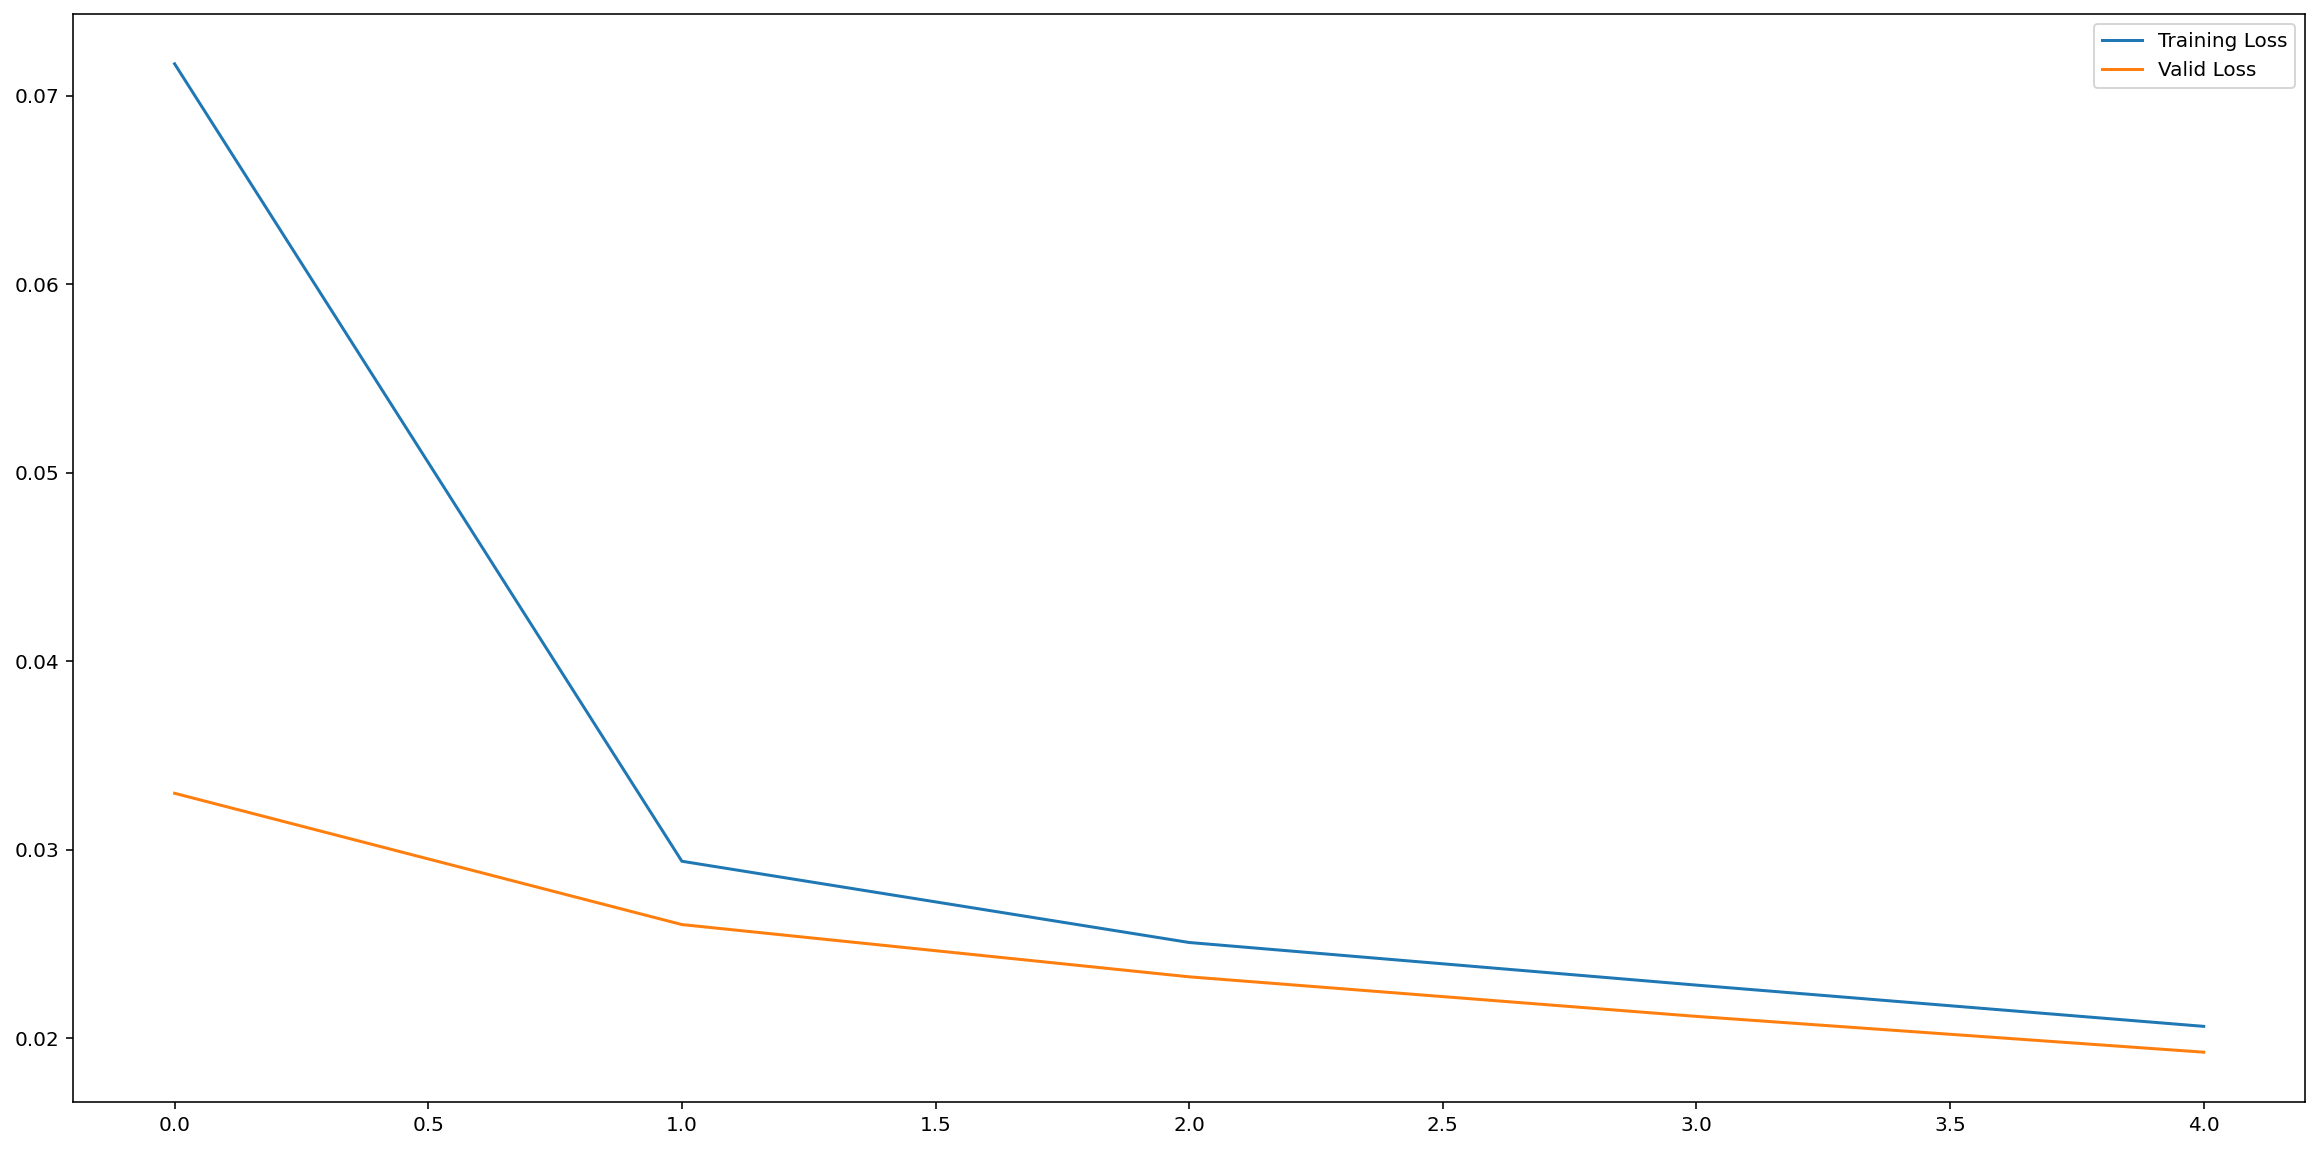

In [18]:
# Vemos la training y valid loss a lo largo de las épocas de entrenamiento

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_Autoencoder.loss_during_training,label='Training Loss')
ax.plot(my_Autoencoder.valid_loss_during_training,label='Valid Loss')
ax.legend()
fig.set_facecolor('white')

Observo rápidamente como ambas funciones decrecen casi a la par. Sin embargo entrenaré el modelo durante más épocas para confirmar mis conclusiones.

In [20]:
# Entrenamos, en este caso, durante 15 épocas

my_Autoencoder = ConvAutoencoder_extended(epochs=15,lr=1e-3,C=16)
my_Autoencoder.trainloop(trainloader,validloader)

The dimension of the latent representation is 1024.000000
Epoch 0. Training loss: 0.072446, Validation loss: 0.032805, Time per epoch: 49.267916 seconds
Epoch 1. Training loss: 0.028695, Validation loss: 0.025334, Time per epoch: 48.400833 seconds
Epoch 2. Training loss: 0.023833, Validation loss: 0.021919, Time per epoch: 47.471868 seconds
Epoch 3. Training loss: 0.021648, Validation loss: 0.020420, Time per epoch: 55.187459 seconds
Epoch 4. Training loss: 0.020355, Validation loss: 0.019415, Time per epoch: 56.204923 seconds
Epoch 5. Training loss: 0.019397, Validation loss: 0.018556, Time per epoch: 50.698452 seconds
Epoch 6. Training loss: 0.018693, Validation loss: 0.017982, Time per epoch: 54.475236 seconds
Epoch 7. Training loss: 0.018143, Validation loss: 0.017398, Time per epoch: 57.146063 seconds
Epoch 8. Training loss: 0.017693, Validation loss: 0.016885, Time per epoch: 45.739885 seconds
Epoch 9. Training loss: 0.017284, Validation loss: 0.016952, Time per epoch: 45.600199 

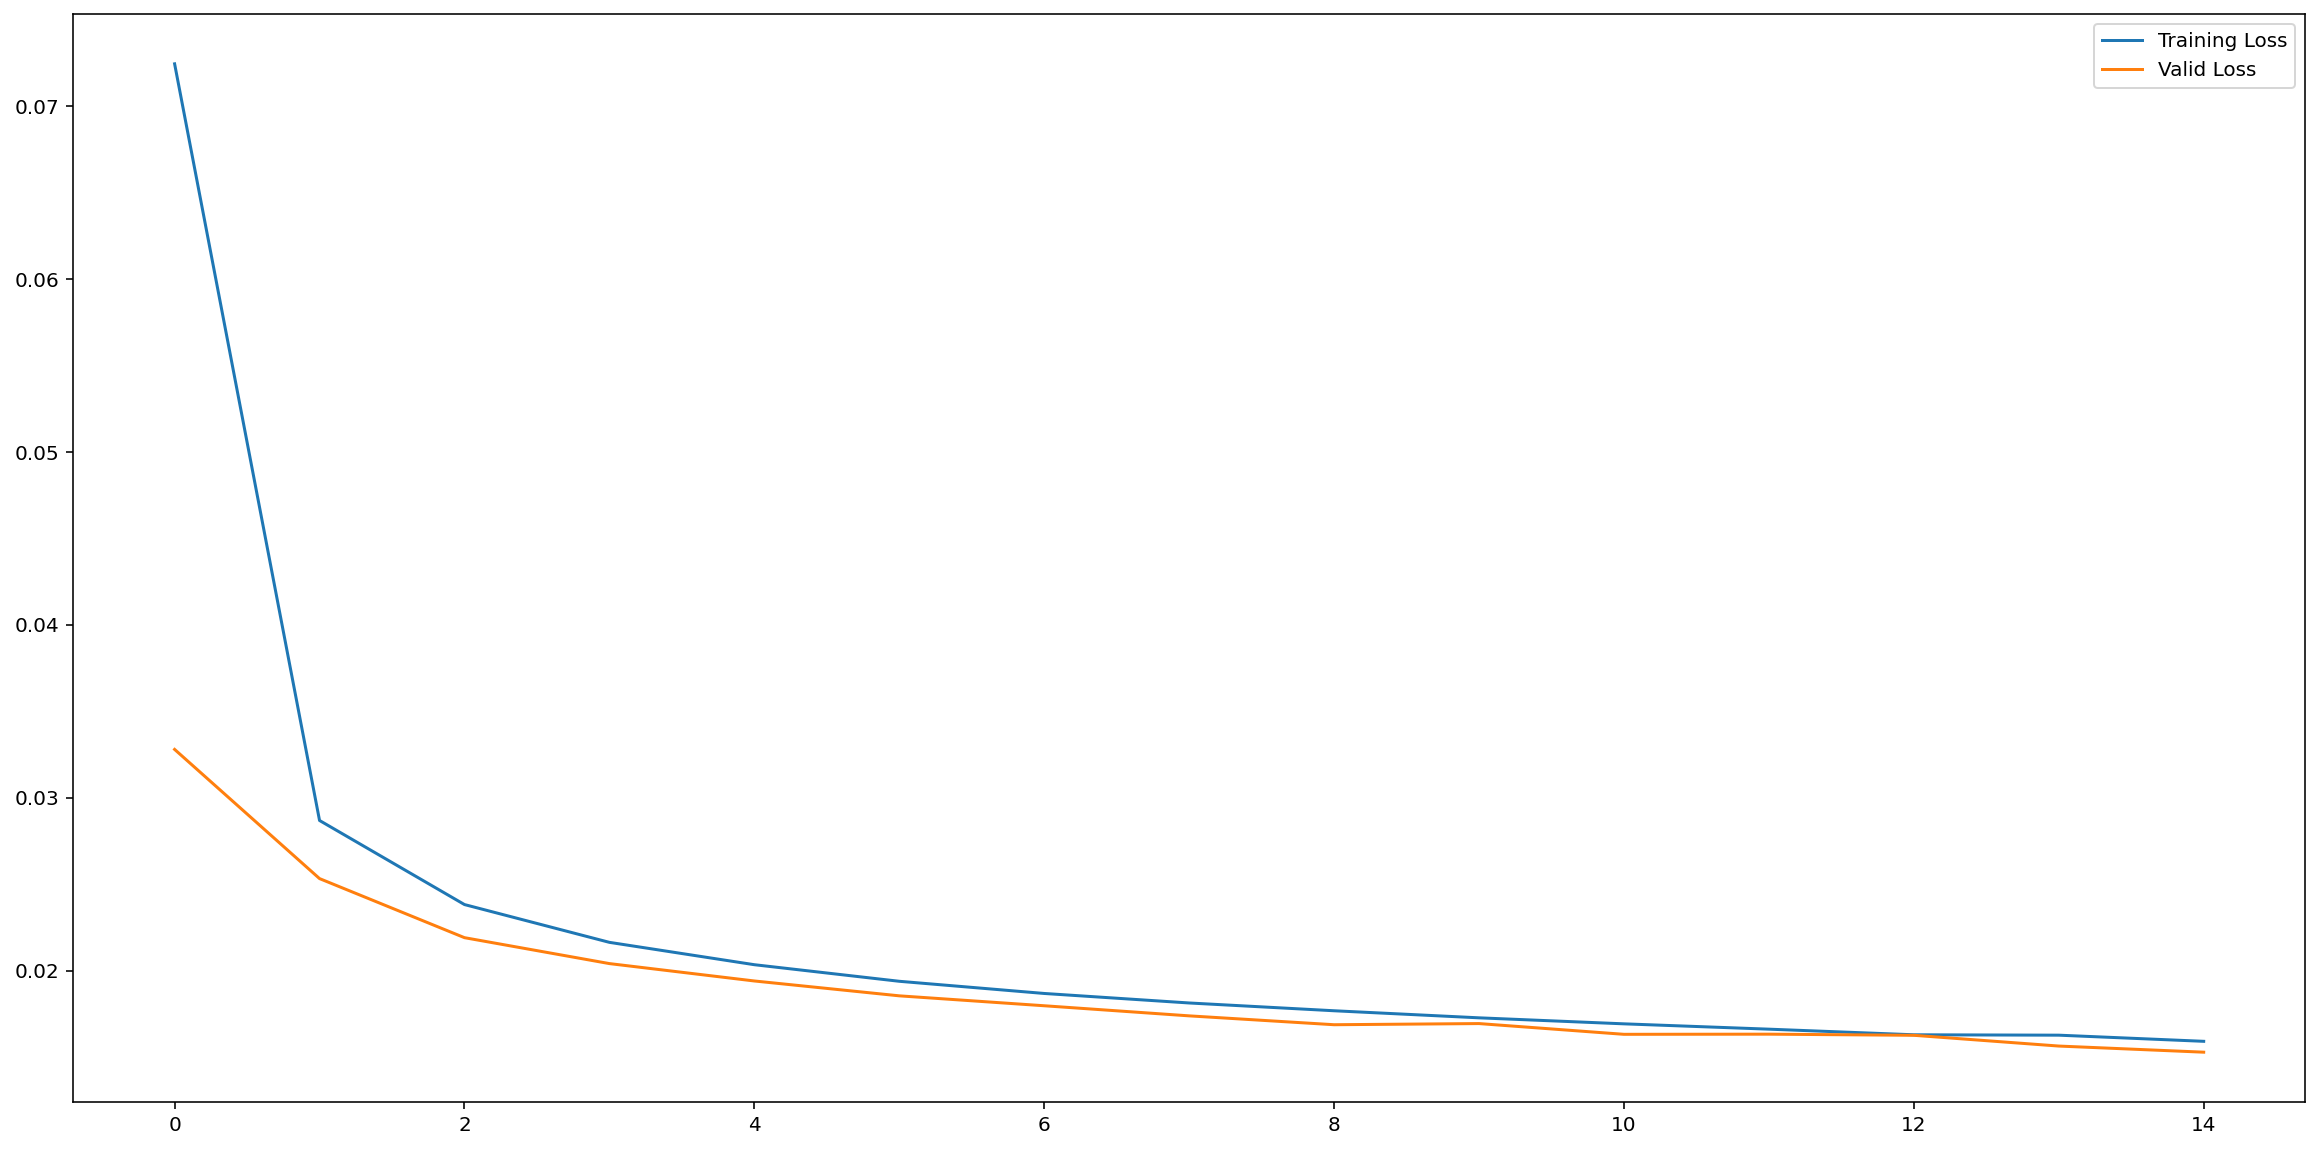

In [21]:
# Vemos la training y valid loss a lo largo de las épocas de entrenamiento

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_Autoencoder.loss_during_training,label='Training Loss')
ax.plot(my_Autoencoder.valid_loss_during_training,label='Valid Loss')
ax.legend()
fig.set_facecolor('white')

Vemos como confirmamos lo que suponiamos anteriormente. A lo largo de 15 épocas, ambas funciones (entrenamiento y validación) siguen descendiendo prácticamente a la par. Con esto confirmamos que el rendimiento del modelo sobre un conjunto de datos ajeno al entrenamiento es bueno, comprobando que no memoriza los de entrenamiento y, por tanto, no tiende (al menos durante las épocas analizadas) al overfitting.

### Checking out the results

Below we plot some of the **test images** along with their reconstructions. These look a little rough around the edges, likely due to the artifacts that tend to happen with transpose layers.

> **Exercise:** Complete the code (just one line!)

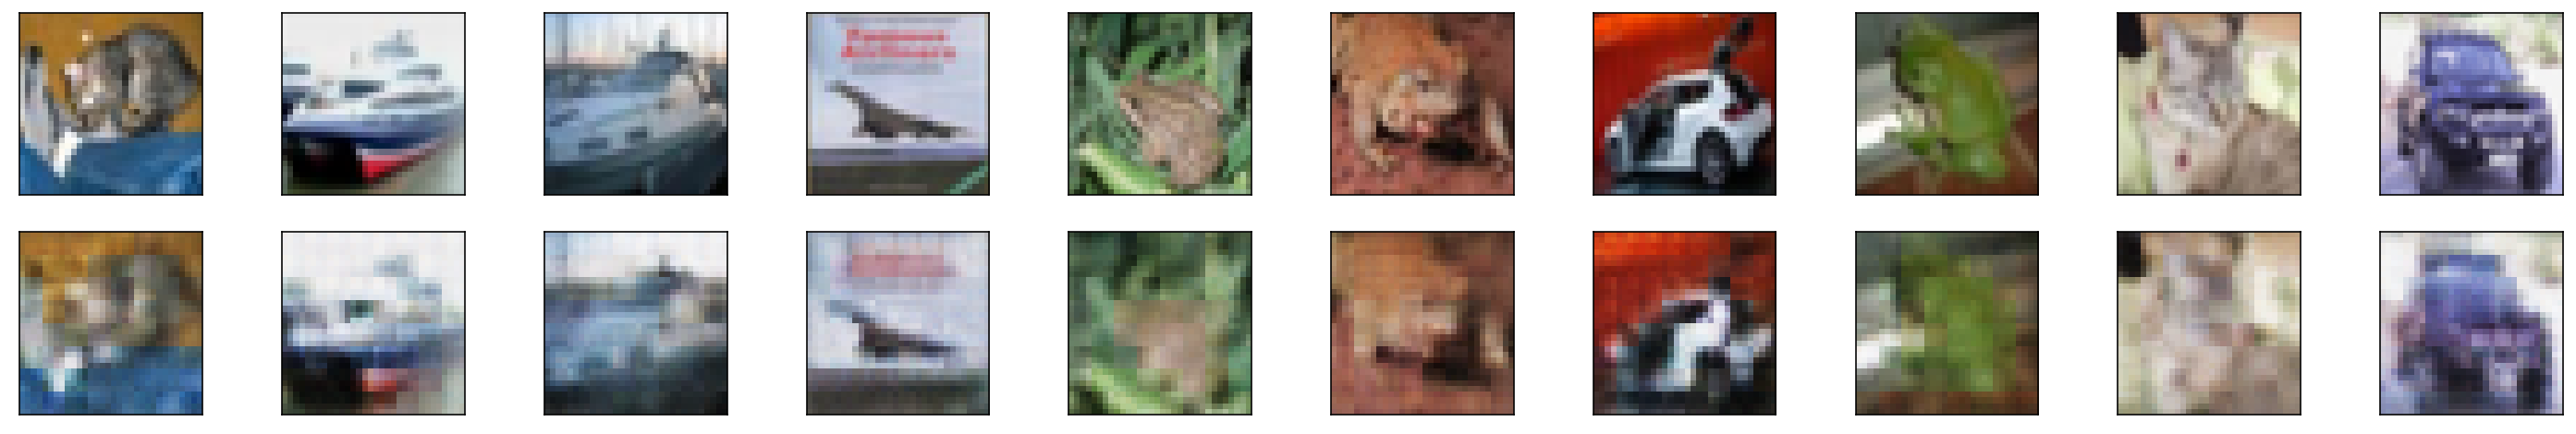

In [23]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

batch_size=256

autoencoder = my_Autoencoder

images_cuda, labels_cuda = images.to(autoencoder.device), labels.to(autoencoder.device)

# latent representation for the minibtach
output,latent = my_Autoencoder.forward(images_cuda)

# prep images for display


# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad. We use .cpu() to move the result back to cpu from gpu
output = output.cpu().detach()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for i in range(10):
    axes[0,i].imshow(rescale(images[i,:,:,:]))
    axes[1,i].imshow(rescale(output[i,:,:,:]))

    axes[0,i].get_xaxis().set_visible(False) # Remove legend
    axes[0,i].get_yaxis().set_visible(False)

    axes[1,i].get_xaxis().set_visible(False) # Remove legend
    axes[1,i].get_yaxis().set_visible(False)    
    

Si bien la reconstrucción no es perfecta (lógicamente se pierde calidad en el paso del encoder + decoder) si son capaces de rehacerse con bastante buena calidad y similitud a las imágenes originales.

## Part IV. Visualizing the effect of the encoder size

To analyze the effect of C, the number of feature maps at the encoder's output, represent the validation loss after training 5 epochs our autoencoder for different values of C between 2 and 32.

The dimension of the latent representation is 128.000000
Epoch 0. Training loss: 0.108914, Validation loss: 0.068127, Time per epoch: 47.987083 seconds
Epoch 1. Training loss: 0.064766, Validation loss: 0.060949, Time per epoch: 58.846387 seconds
Epoch 2. Training loss: 0.060206, Validation loss: 0.057767, Time per epoch: 45.823479 seconds
Epoch 3. Training loss: 0.057607, Validation loss: 0.055705, Time per epoch: 45.145029 seconds
Epoch 4. Training loss: 0.056010, Validation loss: 0.054294, Time per epoch: 44.625328 seconds
The dimension of the latent representation is 256.000000
Epoch 0. Training loss: 0.091253, Validation loss: 0.049385, Time per epoch: 42.962820 seconds
Epoch 1. Training loss: 0.044643, Validation loss: 0.040714, Time per epoch: 43.032204 seconds
Epoch 2. Training loss: 0.039341, Validation loss: 0.036978, Time per epoch: 46.879620 seconds
Epoch 3. Training loss: 0.036676, Validation loss: 0.035529, Time per epoch: 43.941329 seconds
Epoch 4. Training loss: 0.03492

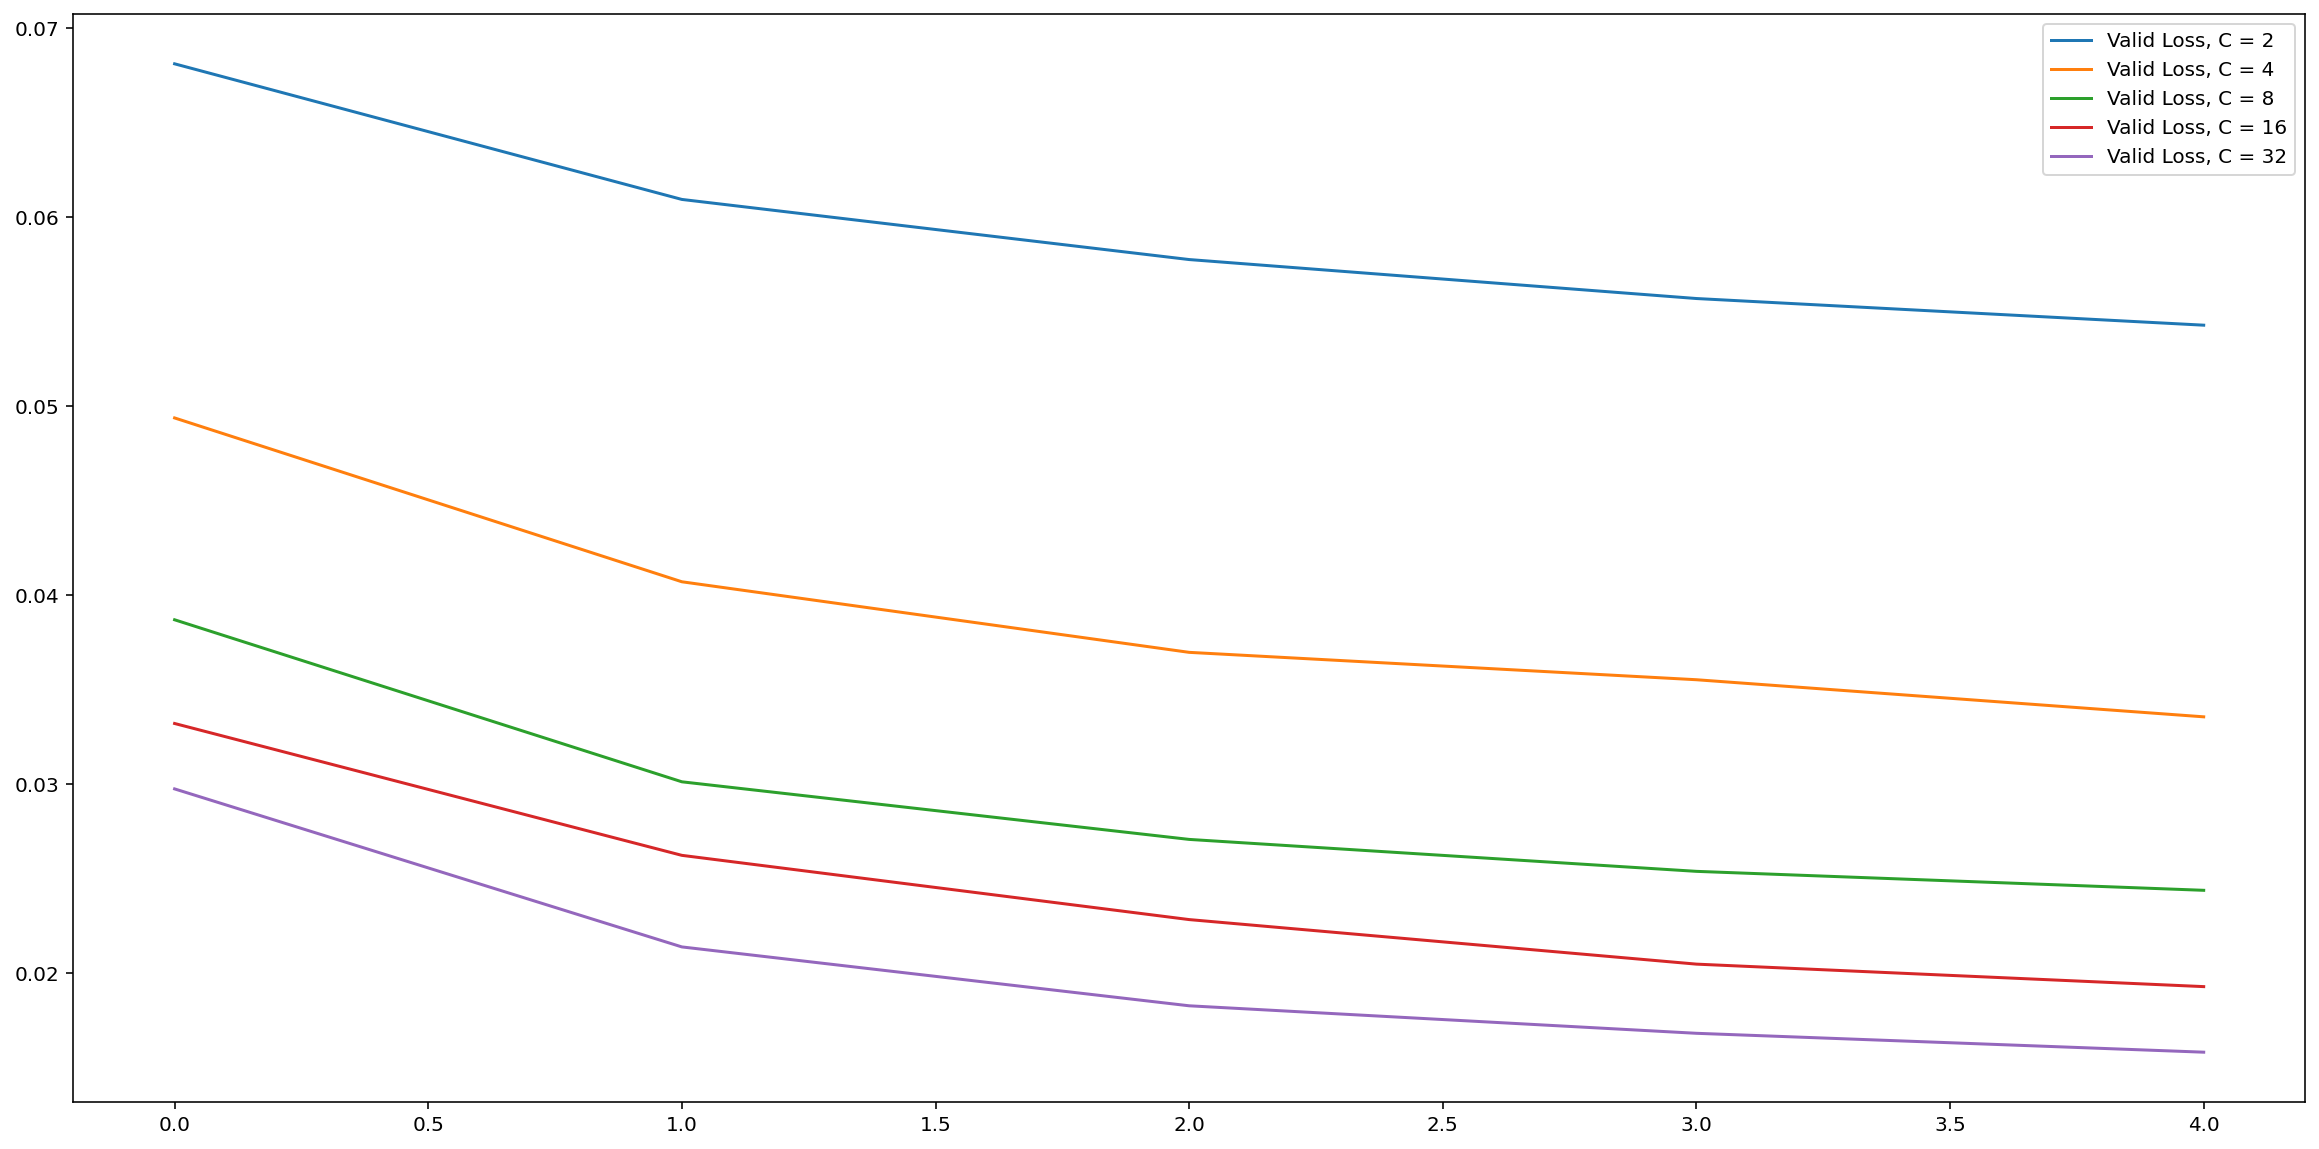

In [35]:
# Your code here

fig, ax = plt.subplots(figsize=(20,10))

j = 2

for i in range (5):
    
    if (i == 0):
        j = 2
    else:
        j = j * 2

    my_Autoencoder_C = ConvAutoencoder_extended(epochs=5,lr=1e-3,C=j)
    my_Autoencoder_C.trainloop(trainloader,validloader)

    ax.plot(my_Autoencoder_C.valid_loss_during_training,label='Valid Loss, C = '+str(j))

ax.legend()
fig.set_facecolor('white')

A primera vista vemos, en general, buenos resultados. Todas las funciones de validación tienen formas parecidas y descienden a lo largo de las épocas (es decir, no contemplamos, de momento, overfitting). A su vez, sacamos una conclusión clara, a mayor es el valor de "C", mejor es el rendimiento del autoencoder en relación a la reconstrucción de la imagen por parte del decoder.

Si lo pensamos de forma sencilla, en cada capa, las dimensiones de los datos que tenemos son altoxanchoxnºde feature maps. Cuando C es muy alto, implica que la salida del autoencoder va a tener una dimensión relativamente grande, por lo que la reducción de la dimensionalidad de la imagen a la entrada de dicho encoder no es demasiado grande, por lo que la reconstrucción de la susodicha imagen por parte del decoder no será tan compleja y el resultado final se parecerá a la entrada del autoencoder, proporcionando mejores resultados en validación (tal y como vemos en la gráfica de arriba).

Por otro lado, si C es muy pequeña, implica que el encoder realizará una mayor reducción de la dimensionalidad. Por este motivo, el trabajo del decoder para volver a la dimensión original de las imágenes de entrada, será más complejo, implicando peores resultados y es por ello que las Cs más pequeñas dan paso a peores resultados en validación.

## Part V. Visualize the data the encoder's output in 2D using t-SNE

[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 100 or 200 variables) if the number of features is very high. At the end, this is what we used the autoencoder for!

> **Exercise** For C=4, compute the latent representation of a mini-batch of CIFAR 10 images. Dont forget to move the latent representation to the cpu (in case a gpu was used).

In [38]:
# YOUR CODE HERE

traindata_SNE = iter(trainloader)       # Introducimos los datos de entrenamientos en un iterador
images, labels = next(traindata_SNE)    # Cogemos el primer batch de 256 imágenes

In [37]:
# Entrenamos el modelo con C=4

my_Autoencoder_SNE = ConvAutoencoder_extended(epochs=15,lr=1e-3,C=4)
my_Autoencoder_SNE.trainloop(trainloader,validloader)

The dimension of the latent representation is 256.000000
Epoch 0. Training loss: 0.097203, Validation loss: 0.051859, Time per epoch: 51.092723 seconds
Epoch 1. Training loss: 0.045827, Validation loss: 0.040264, Time per epoch: 44.327974 seconds
Epoch 2. Training loss: 0.038931, Validation loss: 0.036608, Time per epoch: 42.841295 seconds
Epoch 3. Training loss: 0.035397, Validation loss: 0.033454, Time per epoch: 44.263351 seconds
Epoch 4. Training loss: 0.033136, Validation loss: 0.031554, Time per epoch: 42.931819 seconds
Epoch 5. Training loss: 0.031734, Validation loss: 0.030574, Time per epoch: 48.590366 seconds
Epoch 6. Training loss: 0.030731, Validation loss: 0.029611, Time per epoch: 49.509385 seconds
Epoch 7. Training loss: 0.030081, Validation loss: 0.028957, Time per epoch: 46.738620 seconds
Epoch 8. Training loss: 0.029389, Validation loss: 0.028580, Time per epoch: 44.556261 seconds
Epoch 9. Training loss: 0.029093, Validation loss: 0.028399, Time per epoch: 42.990369 s

In [41]:
# Obtenemos el latent de un bach de imágenes

images_SNE = my_Autoencoder_SNE.forward(images)[1]

We implement TSNE using sklearn implementation

In [43]:

from sklearn.manifold import TSNE

# Reshape latent representation to a single vector
latent = images_SNE.reshape(batch_size,-1)
images_np = np.squeeze(images)

latent_tsne = TSNE(n_components=2).fit_transform(latent.detach().numpy())


d:\anaconda\envs\ids\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda\envs\ids\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [51]:
# With this code we can visualize images in a 2D scatter plot

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
 
def plot_latent_space_with_images(images,latent,xmin=-1,xmax=1,ymin=-1,ymax=1):
 
    # images --> Minibatch of images (numpy array!)
    # latent --> Matrix of 2D representations (numpy array!)
 
    f, ax = plt.subplots(1,1,figsize=(15, 20))
    # ax is a figure handle
    ax.clear()
    for i in range(len(images)):
        im = OffsetImage(rescale(images[i,:,:,:]))
        ab = AnnotationBbox(im, latent[i,:],frameon=False)
        ax.add_artist(ab)
    #We set the limits according to the maximum and minimum values found for the latent projections
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Latent space Z with Images')

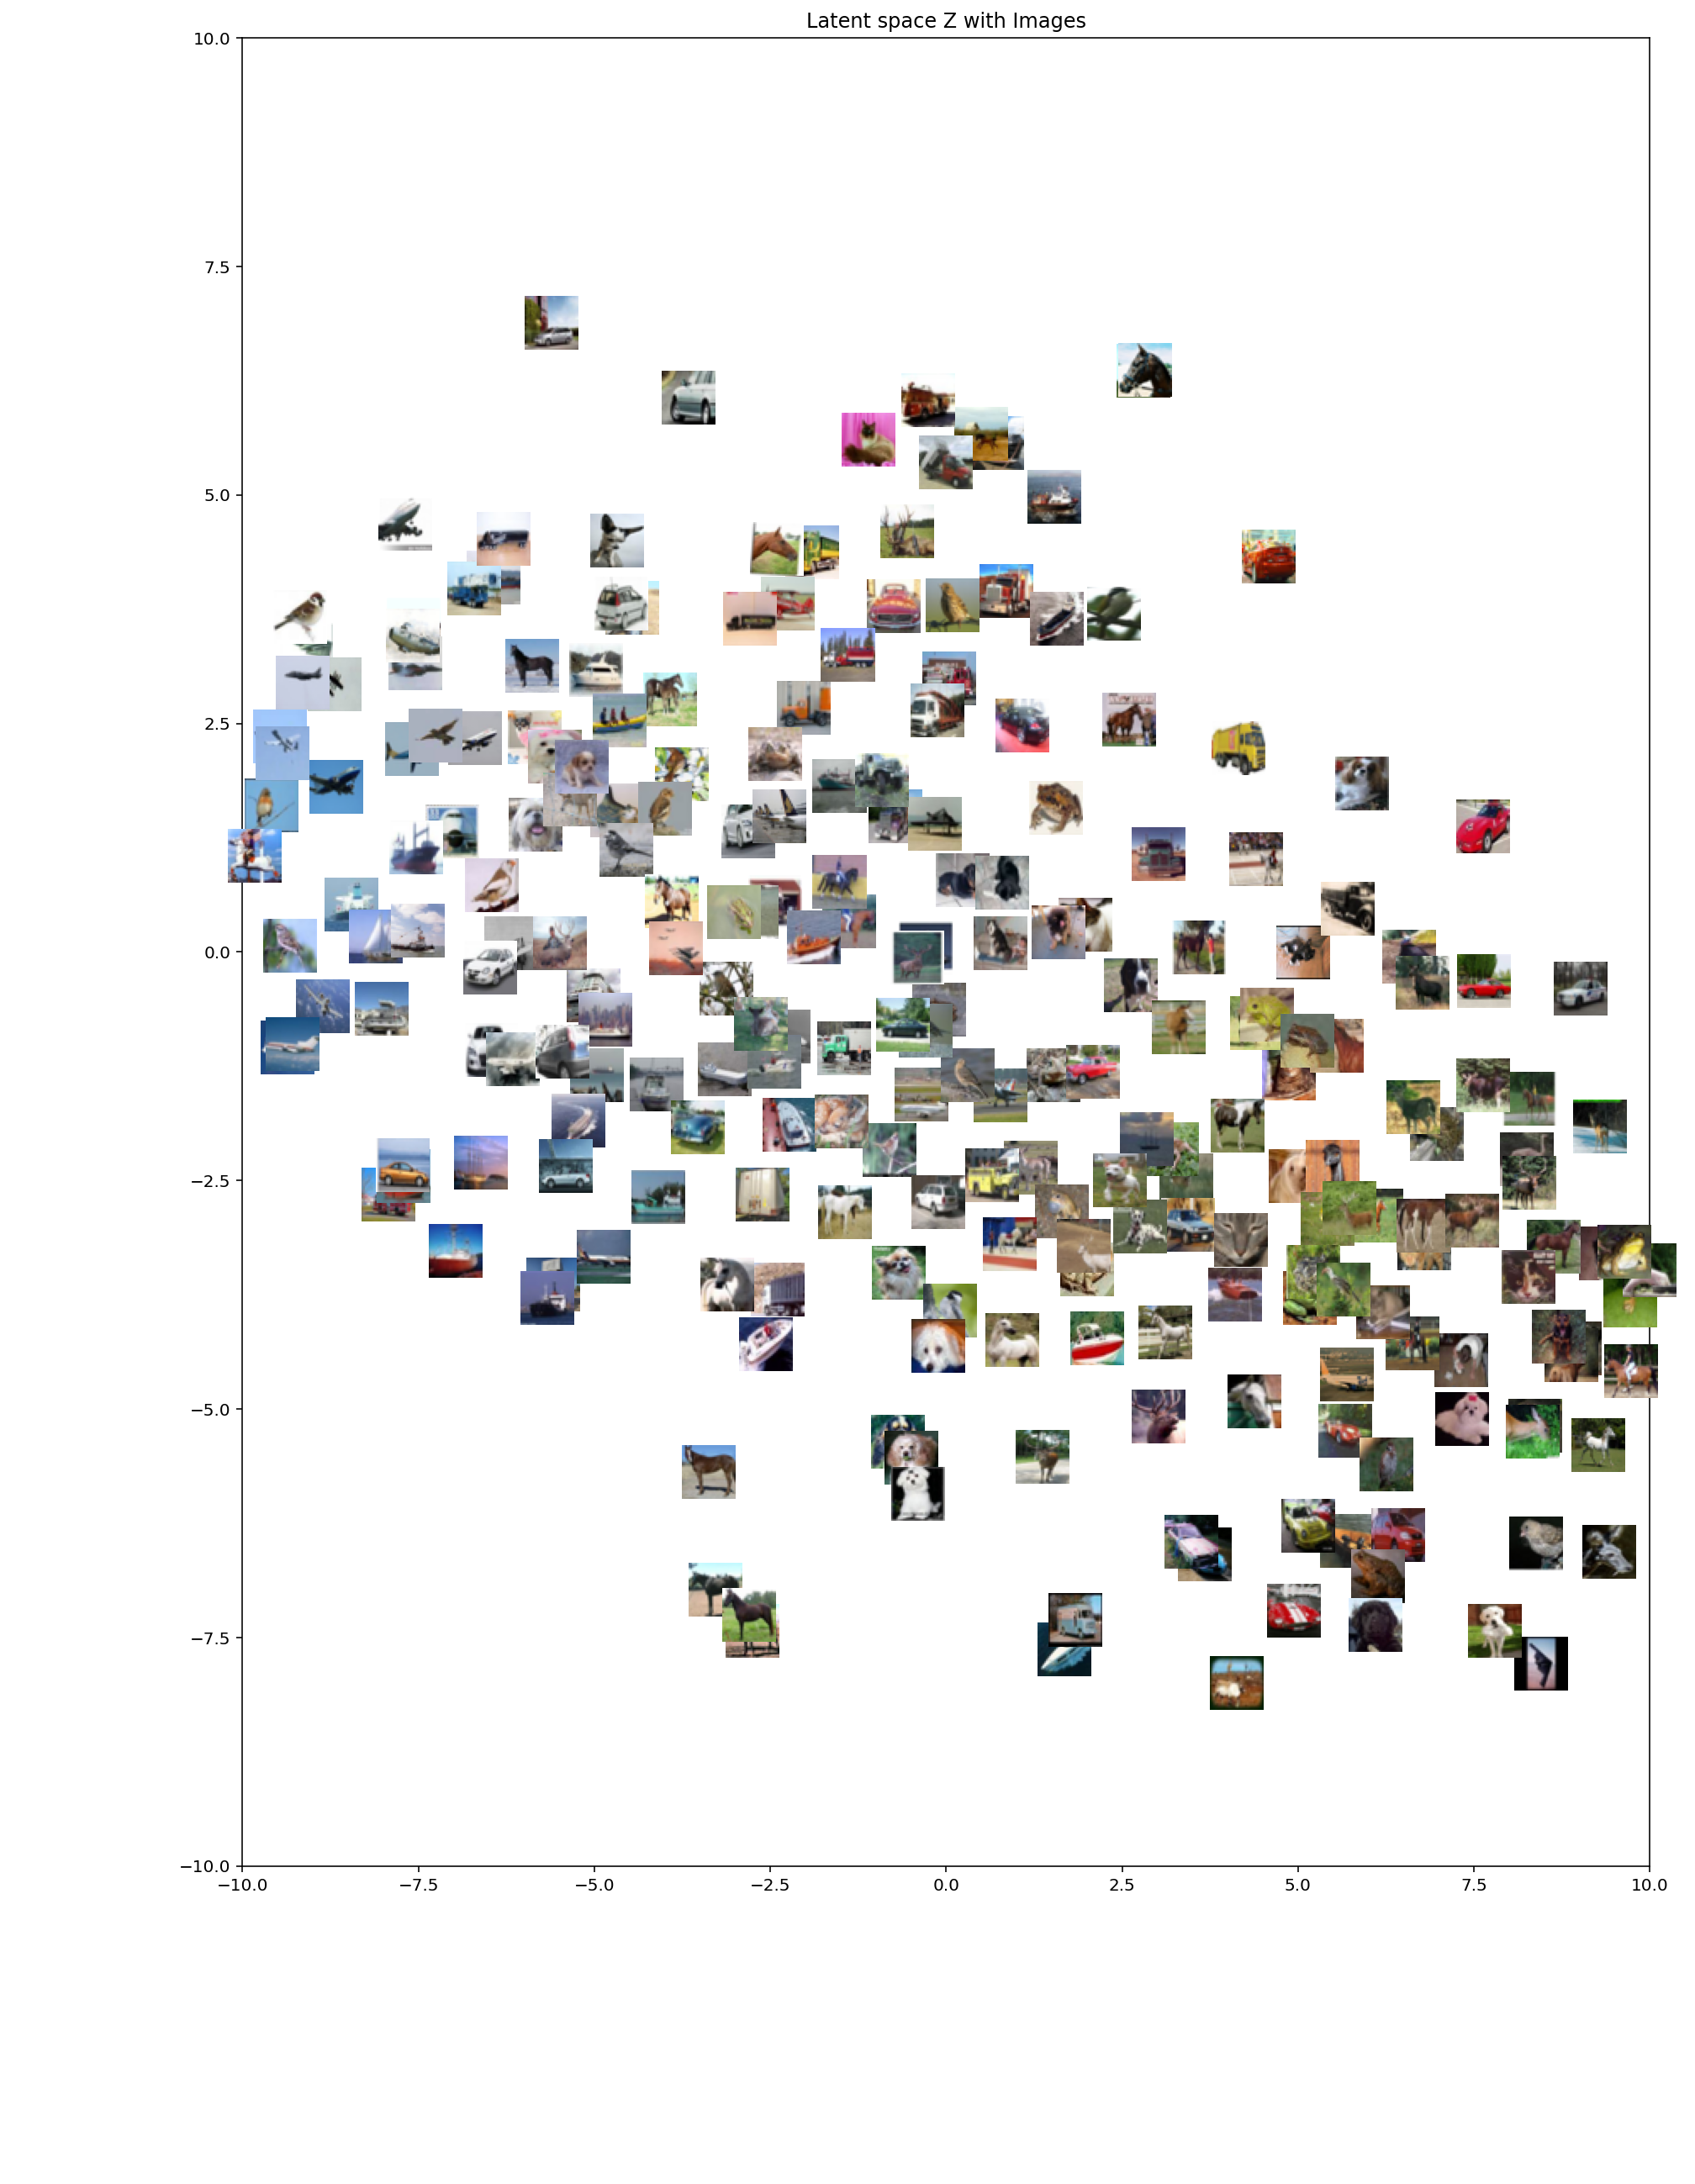

In [52]:
plot_latent_space_with_images(images, latent_tsne,-10,10,-10,10)

Do the neighbours in the 2D space make any sense?

Sabemos que el objetivo es realizar un "cluster" de las clases de las imágenes que le hemos introducido. Si observamos un poco las agrupaciones vemos cosas con lógica: Conjuntos de perros, pajaros y aviones cerca entre sí (ya que se parecen mucho), los caballos se agrupan entre sí y se encuentra cerca de un grupo formado por coches + camiones (que, generalmente están cerca)... Todo en función de su apariencia, es decir, no todos los perros se agrupan juntos, sino que se agrupan con perros parecidos a ellos.

Si bien el resultado no es perfecto, vemos con facilidad la tendencia y la lógica de los clusters realizados.